# 初期設定

In [1]:
#削除
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


yolov5のインストール

In [2]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [3]:
cd yolov5

/content/yolov5


In [4]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import time
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.notebook import trange
import os
import torch
import matplotlib.pyplot as plt
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
import shutil
from google.colab import files
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-26 Python-3.9.16 torch-2.0.0+cu118 CPU



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


100%|██████████| 14.1M/14.1M [00:00<00:00, 76.8MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


MODNetのインストール

In [6]:
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

/content
/content/MODNet


In [7]:
%cd /content/MODNet
 
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

/content/MODNet


In [8]:
def detect_img(img):
  results = model(img)
  for i, (im, pred) in enumerate(zip(results.ims, results.pred)):
    s = f'image {i + 1}/{len(results.pred)}: {im.shape[0]}x{im.shape[1]} '  # string
    if pred.shape[0]:
      for c in pred[:, -1].unique():
        n = (pred[:, -1] == c).sum()  # detections per class
        s += f"{n} {results.names[int(c)]}{'s' * (n > 1)}, "  # add to string
    else:
      s += '(no detections)'
  return "person" in s

In [9]:
os.chdir("/content")
#削除


# データの入力

In [10]:
from google.colab import files
import io


In [57]:
uploaded=files.upload()
file_name = list(uploaded.keys())[0]

IndexError: ignored

In [14]:
input_path = "sample_data/input_data.JPG"
shutil.move(file_name, input_path)
file_name = "input_data.JPG"
img = Image.open(input_path)
if detect_img(img):
  img_file = cv2.imread(input_path)
  cv2_imshow(img_file)
else:
  print("Please, upload again.")

FileNotFoundError: ignored

In [15]:
input_folder = '/content/input'
if not os.path.exists(input_folder):
  os.makedirs(input_folder)
try:
  shutil.move(input_path, input_folder)
except:
  print("already moved")
  
output_folder = '/content/output'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)

background_folder = '/content/drive/MyDrive/00 system/data'
if not os.path.exists(background_folder):
  os.makedirs(background_folder)


In [16]:
%cd /content/MODNet

/content/MODNet


In [17]:
!pip install shell-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
from shell_utils import shell

In [19]:
shell("""
python -m demo.image_matting.colab.inference \
    --input-path /content/input \
    --output-path /content/output \
    --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt
"""
)

root@15f13785f8ef executing...
python -m demo.image_matting.colab.inference     --input-path /content/input     --output-path /content/output     --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



CompletedProcess(args='python -m demo.image_matting.colab.inference     --input-path /content/input     --output-path /content/output     --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt', returncode=0)

In [20]:
def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  return foreground

In [21]:

os.chdir("/content")

matte_name = file_name.split('.')[0] + '.png'
image = Image.open(os.path.join(input_folder, file_name))
matte = Image.open(os.path.join(output_folder, matte_name))
foreground = combined_display(image, matte).astype(np.uint8)
foreground = cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR)
cv2.imwrite(os.path.join(background_folder, matte_name),foreground)


True

In [43]:
FILE_PATH = ["data/"+ file_name.split('.')[0] + '.png']

# 検索結果

In [23]:
os.chdir("/content/drive/MyDrive/00 system")

In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals
import torch
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import CenterCrop

import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from sklearn.model_selection import train_test_split
import math
from numpy.core.memmap import uint8
from tqdm.notebook import trange
import pickle
import seaborn as sns

In [47]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, file_list ,transform=None, phase = 'train'):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase
    self.transform_num3 = transforms.Grayscale(num_output_channels=3)
    

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self,idx):
   img_name = self.file_list[idx]
   label= img_name.split("_")[0]

   if label == "data/input":
     label="input"
     img_path = img_name
   else:
     img_path = label +"/"+ img_name

   img = cv2.imread(img_path)
   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

   if img.shape[2] != 3:
     img = self.transform_num3(img)

   img = torch.from_numpy((img.astype(np.float64)/255).transpose(2,0,1)).clone().float()

   

   img_transformed = self.transform(img)

   return img_transformed, label

In [26]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()

    self.input_num = 25600
    self.input_size = [64, 20, 20]
    self.conv1= nn.Conv2d(3, 32, 5,stride=1,padding=0)
    self.conv2= nn.Conv2d(32, 64, 5,stride=3,padding=2)
    self.fc1  = nn.Linear(self.input_num,4000)
    self.fc11 = nn.Linear(4000,400)
    self.fc21 = nn.Linear(400,20)
    self.fc22 = nn.Linear(400, 20)
    self.fc3  = nn.Linear(20, 400)
    self.fc4  = nn.Linear(400, 4000)
    self.fc5  = nn.Linear(4000,self.input_num)
    self.conv3= nn.ConvTranspose2d(64,32,5,stride=3,padding=1)
    self.conv4= nn.ConvTranspose2d(32,3,5,stride=1,padding=0)
    

  def encode(self, x):
      h1  = F.relu(self.conv1(x))
      h12 = F.relu(self.conv2(h1))
      h13 = F.relu(self.fc1(h12.view(-1,self.input_num)))
      h14 = F.relu(self.fc11(h13))
      return self.fc21(h14), self.fc22(h14)

  def reparameterize(self, mu, logvar):
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      return mu + eps*std

  def decode(self, z):
      h3 = F.relu(self.fc3(z))
      h31 = F.relu(self.fc4(h3))
      h32 = F.relu(self.fc5(h31))
      h33 = F.relu(self.conv3(h32.view(-1,self.input_size[0],self.input_size[1],self.input_size[2])))
      return torch.sigmoid(self.conv4(h33))

  def forward(self, x):
      mu, logvar = self.encode(x)
      z = self.reparameterize(mu, logvar)
      return self.decode(z), mu, logvar

In [27]:
model=VAE()
model.load_state_dict(torch.load("bin/vae.pth"))

<All keys matched successfully>

In [48]:
transform =transforms.Compose([transforms.Resize(54),transforms.CenterCrop(64)])
FILE_SET = MyDataset(FILE_PATH,transform=transform)
FILE_LOADER = torch.utils.data.DataLoader(FILE_SET,batch_size=1,shuffle = False)

input


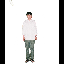

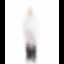

In [49]:
for i, (data,_) in enumerate(FILE_LOADER):
  print(_[0])  
  im2=cv2.cvtColor(np.array(data.view(3,64,64).detach().numpy().transpose(1,2,0)*255,uint8), cv2.COLOR_RGB2BGR)
  cv2_imshow(im2)
  y, _, _ = model(data)
  im = cv2.cvtColor(y.view(3,64,64).detach().numpy().transpose(1,2,0)*255, cv2.COLOR_RGB2BGR)
  cv2_imshow(im)
  break

In [50]:
brands=np.load("bin/brands.npz.npy")
params=np.load("bin/params.npz.npy")

In [51]:
for i, (data,lab) in enumerate(FILE_LOADER):
  y, a, b = model(data)  
  
  if i==0:
    
    input_param = model.reparameterize(a,b).detach().numpy()
    input_label   = np.array(lab)
  else :
    z = model.reparameterize(a,b).detach().numpy()
    input_label=np.append(input_label,np.array(lab))
    input_param=np.vstack([input_param,z])

In [54]:
k=388

In [55]:
ranking=pd.DataFrame(range(0,40),columns=["index"])
for ex,val in enumerate(input_param):       
  d_sort = np.sqrt(((params)**2).sum(axis=1)).argsort()
  unique =np.unique(brands[d_sort[0:k]],return_counts=True)
  # print(brands_te[ex])
  # print(unique[0])
  # print(unique[1])
  # print(unique[0][unique[1].argsort()[::-1]])
  # try:
  rank=pd.DataFrame(unique[0][unique[1].argsort()[::-1]],columns=[input_label[ex]])
  # print((np.where(rank == brands_te[ex])[0][0]+1)/len(unique[0]))
  # ranking.loc[str(ex)] = [user_eval[ex],(np.where(rank == brands_te[ex])[0][0])/len(unique[0]-1)]
  ranking = pd.concat([ranking,rank],axis=1)
  # bool_list.append(brands_te[ex] in brands_tr[d_sort[0:78]])
  # except:
  #   not_exist+=1
  #   ranking.loc[str(ex)] = [brands_te[ex], 1]


  
# plt.hist(ranking["ranking"])
# print(not_exist)
ranking

,index,input
0,0,archiver
1,1,adidas
2,2,nike
3,3,wego
4,4,innocent-
5,5,dickies
6,6,diesel
7,7,funalive
8,8,outdoorproducts
9,9,avirex
